In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import gurobipy as gp
from gurobipy import GRB
import cvxpy as cp

import random
from itertools import chain, combinations, tee
import time

# Load Input Data:

In [2]:
vot_pdf = np.genfromtxt('../original_code/VOT_distr.csv', delimiter=',')[1:]
vots = []
vot_p = []
for row in vot_pdf:
    vots.append(row[0])
    vot_p.append(row[1])
print(vot_p)
print()
vot_p=vot_p/np.sum(vot_p)
print(vot_p)

[0.01, 0.02, 0.01, 0.02, 0.02, 0.02, 0.02, 0.04, 0.02, 0.07, 0.02, 0.07, 0.16, 0.13, 0.05, 0.25, 0.03, 0.05]

[0.00990099 0.01980198 0.00990099 0.01980198 0.01980198 0.01980198
 0.01980198 0.03960396 0.01980198 0.06930693 0.01980198 0.06930693
 0.15841584 0.12871287 0.04950495 0.24752475 0.02970297 0.04950495]


# Travel time functions:

In [3]:
###### BPR Parameters ###### 
bpr_true_capacity = 66
bpr_true_fftt = 60*22/67
bpr_true_alpha = 0.2

def true_bpr_cost(flow_val, fftt = bpr_true_fftt, capacity = bpr_true_capacity, alpha = bpr_true_alpha):
    """
    Find the (exact) travel time on an edge given an edge flow
    """

    return fftt * (1+alpha*(flow_val/capacity)**6)

###### Approximation Parameters ###### 
const_multiplier = 1
cap_thresh_multiplier = 0.7835
apx_slope = 0.314

def apx_bpr_cost(flow_val, fftt = bpr_true_fftt, capacity = bpr_true_capacity, 
                a = const_multiplier, cap_thresh = cap_thresh_multiplier, b = apx_slope):
    """
    Find the (approximate) travel time on an edge given an edge flow
    """
    
    if flow_val <= cap_thresh*capacity:
        return a*fftt
    else:
        return a*fftt + b*(flow_val - cap_thresh*capacity)

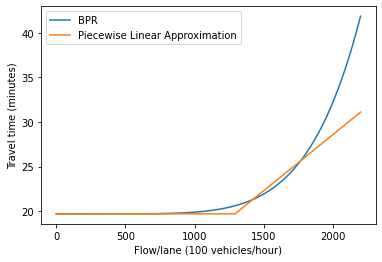

In [4]:
###### Check plots of BPR and approximation ###### 
multiplier = 100/4 # converts from 100 vehicles/hour --> vehicle/hour per lane

x =  np.linspace(0,int(np.round(88*multiplier,0)),int(np.round(89*2*multiplier,0)))
y = [true_bpr_cost(i, capacity = bpr_true_capacity*multiplier) for i in x]

plt.plot(x, y,label='BPR')

y_apx = [apx_bpr_cost(i,capacity = bpr_true_capacity*multiplier, b = apx_slope/multiplier) for i in x]

plt.plot(x, y_apx,label='Piecewise Linear Approximation')
plt.xlabel("Flow/lane (100 vehicles/hour)")
plt.ylabel("Travel time (minutes)")
plt.legend(loc='upper left')

# Generate Demand Profile:

In [5]:
###### Specify parameters for problem ###### 
T = 5 # Time Horizon
tau_arr = 20*np.linspace(0, 1, 21)[0:] # Toll discretization
print('Tau:\n {}'.format(tau_arr))
print()

B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) # Budget discretization 
print('B:\n {}'.format(B_arr))
print()

num_total = 8000 # number of users
num_eligible =int( num_total*.17) # number of eligible users
num_ineligible = num_total-num_eligible # number of ineligible users

###### VoT information ###### 
vot_all = np.sort(np.round(np.random.choice(vots, size = num_total, p=vot_p),2)/60) # generate baseline VoT for all users
vot_all_days = np.empty(shape=(num_total,T)) 
count=0
for v in vot_all:
    if count < num_eligible:
        vot_all_days[count,:]=[v for t in range(T)] # VoT of eligible users does not vary over time periods
    else:
        vot_all_days[count,:]=list((1+0.25*(np.random.random_sample(size=T)-0.5))*v) # VoT of ineligible users varies over time periods
    count+=1
    
vot_eligible = vot_all_days[:num_eligible,:]
vot_ineligible= vot_all_days[num_eligible:,:]

print('Eligible vot range:\n {} ({} $/hr), {} ({} $/hr)'.format(np.min(vot_eligible),60*np.min(np.round(vot_eligible,2)),np.max(np.round(vot_eligible,2)),60*np.max(np.round(vot_eligible,2))))
print()
print('Ineligible vot range:\n {}({} $/hr), {} ({} $/hr)'.format(np.min(np.round(vot_ineligible,2)),60*np.min(np.round(vot_ineligible,2)),np.max(np.round(vot_ineligible,2)),60*np.max(np.round(vot_ineligible,2))))
print()
print('Mean vot:\n {} $/hr; median: {} $/hr'.format(60*np.round(np.mean(vot_all_days),2),60*np.round(np.median(vot_all_days),2)))

Tau:
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]

B:
 [ 0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80. 85.
 90.]

Eligible vot range:
 0.02 (1.2 $/hr), 0.24 (14.399999999999999 $/hr)

Ineligible vot range:
 0.21(12.6 $/hr), 2.7 (162.0 $/hr)

Mean vot:
 45.0 $/hr; median: 37.8 $/hr


Text(0, 0.5, '% of population')

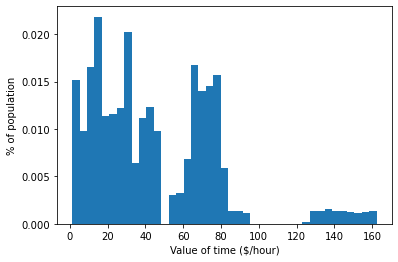

In [6]:
###### Check VoT distribution ###### 
plt.hist(vot_all_days.flatten()*60,bins=41,density=True)
plt.xlabel("Value of time ($/hour)")
plt.ylabel("% of population")

# Define Social Objectives of Interest:

In [7]:
###### Estimate VoT percentiles for ineligible group ###### 
percentiles = {}
thresh = 10
for p in range(11):
    print(np.round(np.percentile(vot_ineligible,p*10)*60,2))
    percentiles[p*10]=np.percentile(vot_ineligible,p*10)

12.62
18.54
23.44
30.29
37.7
44.51
63.72
68.82
74.66
79.97
162.24


# Solver 1, Budget:

In [64]:
def OptPL_budget(toll, B, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible, 
            vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
              fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity, c_2 = bpr_true_capacity, 
             a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope, b_2 = apx_slope):
    """
    Function to solve convex optimization problem given a particular toll and budget value
    """
    
    # Initialize model
    m1 = gp.Model()
    # Add variables to model
#     users_in = m1.addVars(num_ineligible, 3, T, name = 'ineligible_val', lb = 0.0, ub = 2.0)
#     edge_flows = m1.addVars(2, T, name = 'edge_flows', lb = 0.0, ub = num_ineligible * 2.0)
#     users_el = m1.addVars(3, T, name = 'eligible_allocation', lb = 0.0, ub = 2.0)
    # Add variables for piecewise affine approximation
#     eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = 0.0, ub = num_ineligible * 2.0)
    
#     # Add variables for piecewise affine approximation
#     eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = 0.0, ub = num_ineligible * 2.0)
    users_in = m1.addVars(num_ineligible, 3, T, name = 'ineligible_val', lb = -10000.0, ub = 10000.0)
    edge_flows = m1.addVars(2, T, name = 'edge_flows', lb = -10000.0, ub = 10000.0)
    users_el = m1.addVars(3, T, name = 'eligible_allocation', lb = -10000.0, ub = 10000.0)
    eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = -10000.0, ub = 10000.0)   

    ## Add constraints to Model 
    
    # Total edge flow, express lane:
    m1.addConstrs((edge_flows[0, t] == sum(users_in[i, 0, t] for i in range(num_ineligible)) + \
                  users_el[0, t] + sum(users_in[i, 1, t] for i in range(num_ineligible)) + \
                  users_el[1, t] for t in range(T)))
    # Total edge flow, general purpose lane:
    m1.addConstrs((edge_flows[1, t] == sum(users_in[i, 2, t] for i in range(num_ineligible)) + \
                  users_el[2, t] for t in range(T)))
    
    # Non-negativity of all flows, and zero flow for "eligible users in ineligible groups":
    m1.addConstrs((users_in[i, j, t]>=0 for i in range(num_ineligible) for j in range(3) for t in range(T)))
    m1.addConstrs((users_in[i, 0, t]==0 for i in range(num_ineligible) for t in range(T)))
    m1.addConstrs((users_el[j, t]>=0 for j in range(3) for t in range(T)))
    # Just to compare with original code:
#     m1.addConstrs((users_el[1, t]==0 for t in range(T)))
    
    # Every eligible and ineligible user is assigned to one of three options: \
    # (express paying, express with credit, non-express)
    m1.addConstrs((sum(users_in[i, j, t] for j in range(3)) == 1 for i in range(num_ineligible) for t in range(T)))
    m1.addConstrs((sum(users_el[j, t] for j in range(3)) == num_eligible for t in range(T)))
    
    # Budget constraint satisfaction:
    if toll != 0:
        m1.addConstr((sum(toll*users_el[0, t] for t in range(T)) <= B * num_eligible))
        
    # Piecewise affine approximation:
    m1.addConstrs((eps_flows[j, t] >= 0 for j in range(2) for t in range(T))) # Must be at least 0
    m1.addConstrs((eps_flows[0, t] >= edge_flows[0, t] - cap_thresh*c_1 for t in range(T))) # Must be at least flow - capacity
    m1.addConstrs((eps_flows[1, t] >= edge_flows[1, t] - cap_thresh*c_2 for t in range(T))) # Must be at least flow - capacity
    
    # Set Objective
    m1.setObjective(sum(a*fftt_1*(edge_flows[0, t]) + b_1*(eps_flows[0, t]**2)/2  
                        + a*fftt_2*(edge_flows[1, t]) + b_2*(eps_flows[1, t]**2)/2 
                        + sum( toll*users_in[i,1,t]/vot_ineligible[i,t] for i in range(num_ineligible))
                        + sum( toll*users_el[1,t]/(vot_eligible[i,t]*num_eligible) for i in range(num_eligible) ) 
        for t in range(T)), GRB.MINIMIZE)
    
    m1.update()
    
    return m1

In [65]:
def _extract_solution_budget(m, num_ineligible = num_ineligible):
    """
    Get solution from optimization model
    """
    users_in = [v.x for v in m.getVars() if v.VarName.find("ineligible_val") != -1]
    users_el = [v.x for v in m.getVars() if v.VarName.find("eligible_allocation") != -1]
    edge_flows = [v.x for v in m.getVars() if v.VarName.find("edge_flows") != -1]
    eps_flows = [v.x for v in m.getVars() if v.VarName.find("eps_flows") != -1]
    
    users_in = np.reshape(users_in, (num_ineligible, 3, T))
    users_el = np.reshape(users_el, (3, T))
    edge_flows = np.reshape(edge_flows, (2, T))
    eps_flows = np.reshape(eps_flows, (2, T))

    solution = {
        "users_in": users_in,
        "users_el": users_el,
        "edge_flows": edge_flows,
        "eps_flows": eps_flows
    }
    return solution

In [66]:
def to_str(num):
    num = int(num)
    
    # For any number < 100:
    if num < 10:
        return str(0) + str(num)
    else:
        return str(num)

# Solve Optimization Problem for Discretized Grid:

## Case 1 - Budget:

In [68]:
# tau_arr = 20 * np.linspace(0, 1, 21)[0:]
# B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) 

# print("tau_arr:\n", tau_arr)
# print()
# print("B_arr:\n", B_arr)

In [69]:
tau_arr = 20 * np.linspace(0, 1, 11)[0:] 
B_arr = np.linspace(0, tau_arr[-1]*4, 9)

print("tau_arr:\n", tau_arr)
print()
print("B_arr:\n", B_arr)

tau_arr:
 [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20.]

B_arr:
 [ 0. 10. 20. 30. 40. 50. 60. 70. 80.]


In [70]:
t_1 = time.time()

demand_multiplier = [25, 75]

# For saving data:
path_directory = "/Users/chih-yuanchiu/Desktop/Code/CBCP_Credit_Discount/data_budget/"

row_names = ["Edge flows", "Eps flows", "Eligible User Flows"]
row_names += ["Ineligible User Flow, " + str(k) for k in list(range(num_ineligible + 1))[1:]]

column_names = []
workday_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
lane_names = ["Express (Credit)", "Express (Paying)", "General Purpose"]
for workday_index, workday in enumerate(workday_names):
    for lane_index, lane in enumerate(lane_names):
        column_names.append(workday + ", " + lane)

## For debugging purposes, truncate tau_arr and B_arr:
# tau_arr = [0.0, 5.0, 10.0, 15.0, 20.0]
# B_arr = [0.0, 5.0, 10.0, 15.0, 20.0]
# tau_arr = [20]
tau_arr = 20 * np.linspace(0, 1, 11)[0:] 
B_arr = np.linspace(0, tau_arr[-1]*4, 9)
# tau_arr = [2.0]
# B_arr = [0.0]


total_count = len(tau_arr) * len(B_arr)

for toll_idx, toll in enumerate(tau_arr):
    for budget_idx, budget in enumerate(B_arr):
        
        print()
        print("Toll:", toll)
        print("Budget:", budget)
        print()
        
        # Construct optimization problem:
        m_budget = OptPL_budget(toll, budget, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible, 
                    vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
                      fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity*demand_multiplier[0], c_2 = bpr_true_capacity*demand_multiplier[1], 
                     a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope/demand_multiplier[0], b_2 = apx_slope/(demand_multiplier[1]))

        # Solve optimization problem:
        m_budget.optimize()
        
        print("Optimal solution obtained:", m_budget.status == GRB.OPTIMAL)
        
        # Extract Solution:
        solution_set = _extract_solution_budget(m_budget)
        
        if toll == tau_arr[0]:
            print()
            print("Edge flows:", solution_set["edge_flows"])
            print()
        
        # Storing data:
        data_edge_flows = np.hstack((np.zeros((5, 1)), solution_set["edge_flows"].T)).reshape(15)
        data_eps_flow = np.hstack((np.zeros((5, 1)), solution_set["eps_flows"].T)).reshape(15)
        data_users_el = solution_set["users_el"].T.reshape(15)
        data_users_in = solution_set["users_in"].transpose(0, 2, 1).reshape((num_ineligible, 5*3))
        data = np.vstack((data_edge_flows, data_eps_flow, data_users_el, data_users_in))
        
        file_name = path_directory + "toll_" + to_str(toll) + "_budget_" + to_str(budget) + ".csv"
        df = pd.DataFrame(data, columns = column_names, index = row_names)        
        df.to_csv(file_name)


t_2 = time.time()
print("Run time:", t_2 - t_1)


Toll: 0.0


Budget: 0.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166055 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0x2b879314
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 166040 rows and 99615 columns
Presolve time: 0.26s
Presolved: 15 rows, 20 columns, 30 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal 

Presolve time: 0.18s
Presolved: 15 rows, 20 columns, 30 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.38120843e+06 -2.17735323e+07  3.98e+02 8.04e+02  1.33e+06     0s
   1   2.02148139e+06 -7.24030726e+06  2.27e-13 8.04e-04  1.85e+05     0s
   2   1.22672981e+06  3.60901377e+05  6.82e-13 1.35e-05  1.73e+04     0s
   3   8.86371925e+05  7.76264517e+05  1.59e-12 1.34e-11  2.20e+03     0s
   4   8.50996400e+05  8.48068733e+05  5.46e-12 5.68e-14  5.86e+01     0s
   5   8.50880829e+05  8.50866231e+05  1.16e-10 1.42e-14  2.92e-01     0s
   6   8.50880702e+05  8.50880687e+05  2.52e-10 5.68e-14  2.92e-04     0s
   7   8.50880702e+05  8.50880702e+05  1.14e-10 0.00e+00  2.92e-07     0s
  

   3   8.86371925e+05  7.76264517e+05  1.59e-12 1.34e-11  2.20e+03     0s
   4   8.50996400e+05  8.48068733e+05  5.46e-12 5.68e-14  5.86e+01     0s
   5   8.50880829e+05  8.50866231e+05  1.16e-10 1.42e-14  2.92e-01     0s
   6   8.50880702e+05  8.50880687e+05  2.52e-10 5.68e-14  2.92e-04     0s
   7   8.50880702e+05  8.50880702e+05  1.14e-10 0.00e+00  2.92e-07     0s
   8   8.50880702e+05  8.50880702e+05  8.61e-13 2.13e-14  2.92e-10     0s

Barrier solved model in 8 iterations and 0.19 seconds (0.15 work units)
Optimal objective 8.50880702e+05

Optimal solution obtained: True

Edge flows: [[2000. 2000. 2000. 2000. 2000.]
 [6000. 6000. 6000. 6000. 6000.]]


Toll: 2.0


Budget: 0.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0xc2a6

  Objective range  [7e-01, 3e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 3e+04]
Presolve removed 166041 rows and 66415 columns
Presolve time: 0.17s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.10294965e+09 -2.12199791e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -3.74776087e+06 -8.68250555e+06  6.29e+03 7.30e-01  1.11e+03     0s
   2   1.12115671e+06 -3.15909749e+06  1.44e+02 1.67e-02  8.60e+01     0s
   3   9.53647942e+05  2.97650404e+05  2.38e+00 2.76e-04  9.96e+00     0s
   4   8.86124415e+05  8.17278936e+05  8.25e-02 9.58e-06  1.04e+00     0s
   5   8.


CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x2912d117
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [7e-01, 3e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 5e+04]
Presolve removed 166041 rows and 66415 columns
Presolve time: 0.17s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.10294965e+09 -2.12199791e+07  6.64e+06 7.7

  40   8.53975355e+05  8.53975354e+05  2.10e-10 5.68e-14  1.62e-08     0s
  41   8.53975354e+05  8.53975354e+05  1.22e-11 5.68e-14  2.26e-11     0s

Barrier solved model in 41 iterations and 0.45 seconds (0.37 work units)
Optimal objective 8.53975354e+05

Optimal solution obtained: True

Budget: 60.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x90b4fdea
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [7e-01, 3e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 8e+04]
Presolve removed 166041 rows and 66415 columns
Presolve time: 0.16s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadrati

  35   8.53976798e+05  8.53973918e+05  4.45e-08 4.46e-12  4.33e-05     0s
  36   8.53976172e+05  8.53974540e+05  1.98e-08 2.08e-12  2.46e-05     0s
  37   8.53975698e+05  8.53975010e+05  3.84e-09 2.77e-13  1.03e-05     0s
  38   8.53975417e+05  8.53975291e+05  6.66e-09 5.68e-14  1.91e-06     0s
  39   8.53975361e+05  8.53975347e+05  1.02e-09 8.53e-14  2.19e-07     0s
  40   8.53975355e+05  8.53975354e+05  2.10e-10 5.68e-14  1.62e-08     0s
  41   8.53975354e+05  8.53975354e+05  1.22e-11 5.68e-14  2.26e-11     0s

Barrier solved model in 41 iterations and 0.42 seconds (0.37 work units)
Optimal objective 8.53975354e+05

Optimal solution obtained: True

Budget: 80.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x574dbf4b
Model has 10

  Objective range  [1e+00, 5e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 1e+04]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.17s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.000e+01
 Factor NZ  : 1.360e+02 (roughly 13 MB of memory)
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.98069057e+09 -2.20151454e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -4.55431362e+06 -9.18683897e+06  6.33e+03 7.35e-01  1.12e+03     0s
   2   1.21080210e+06 -3.07510187e+06  7.98e+01 9.27e-03  7.66e+01     0s
   3   9.94967093e+05  4.94263634e+05  1.69e+00 1.97e-04  7.59e+00     0s
   4   9.10431505e+05  8.21964465e+05  1.59e-01 1.84e-05  1.33e+00     0s
   5   8.

  17   8.56669485e+05  8.56223443e+05  4.29e-08 4.44e-12  6.71e-03     0s
  18   8.56628119e+05  8.56265957e+05  3.29e-08 3.32e-12  5.45e-03     0s
  19   8.56579863e+05  8.56317328e+05  2.46e-08 2.38e-12  3.95e-03     0s
  20   8.56558164e+05  8.56339451e+05  2.08e-08 1.82e-12  3.29e-03     0s
  21   8.56539349e+05  8.56358441e+05  1.57e-08 1.29e-12  2.72e-03     0s
  22   8.56511824e+05  8.56387049e+05  7.55e-09 8.81e-13  1.88e-03     0s
  23   8.56494237e+05  8.56405110e+05  7.87e-09 6.32e-13  1.34e-03     0s
  24   8.56486389e+05  8.56412967e+05  1.00e-08 4.62e-13  1.10e-03     0s
  25   8.56475339e+05  8.56424091e+05  1.07e-08 2.77e-13  7.71e-04     0s
  26   8.56468161e+05  8.56431185e+05  8.38e-09 1.14e-13  5.56e-04     0s
  27   8.56458765e+05  8.56440733e+05  1.50e-08 5.68e-14  2.71e-04     0s
  28   8.56453106e+05  8.56446464e+05  3.73e-08 5.68e-14  1.00e-04     0s
  29   8.56450962e+05  8.56448624e+05  4.22e-09 5.68e-14  3.52e-05     0s
  30   8.56450506e+05  8.56449084e+05 

  30   8.56450506e+05  8.56449084e+05  3.77e-09 1.14e-13  2.14e-05     0s
  31   8.56449833e+05  8.56449758e+05  1.77e-10 1.14e-13  1.13e-06     0s
  32   8.56449796e+05  8.56449795e+05  7.82e-09 1.14e-13  1.31e-09     0s

Barrier solved model in 32 iterations and 0.41 seconds (0.32 work units)
Optimal objective 8.56449796e+05

Optimal solution obtained: True

Budget: 60.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x855e5074
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [1e+00, 5e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 8e+04]
Presolve removed 166041 rows and 66415 columns
Presolve time: 0.16s
Presolv

Presolve time: 0.16s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.98108463e+09 -2.11650922e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -4.52214746e+06 -8.62761680e+06  6.29e+03 7.31e-01  1.11e+03     0s
   2   1.15447077e+06 -3.10488880e+06  1.42e+02 1.65e-02  8.58e+01     0s
   3   9.92508653e+05  3.42697162e+05  2.59e+00 3.00e-04  9.88e+00     0s
   4   9.12640966e+05  7.95065580e+05  2.83e-01 3.28e-05  1.78e+00     0s
   5   8.75015436e+05  8.03905445e+05  9.48e-02 1.10e-05  1.07e+00     0s
   6   8.74533225e+05  8.13876674e+05  5.93e-02 6.88e-06  9.14e-01     0s
   7   8.74047188e+05  8.16789035e+05  4.11e

Optimal objective 8.78957861e+05

Optimal solution obtained: True

Budget: 20.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x6c87b92c
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [2e+00, 8e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 3e+04]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.18s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.000e+01
 Factor NZ  : 1.360e+02 (roughly 13 MB of memory)
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

            

  19   8.58438003e+05  8.58421509e+05  1.01e-08 6.18e-13  2.48e-04     0s
  20   8.58433256e+05  8.58426307e+05  4.37e-09 1.14e-13  1.05e-04     0s
  21   8.58430997e+05  8.58428581e+05  1.09e-08 1.14e-13  3.64e-05     0s
  22   8.58430032e+05  8.58429548e+05  4.21e-09 1.14e-13  7.29e-06     0s
  23   8.58429796e+05  8.58429784e+05  1.22e-09 1.14e-13  1.83e-07     0s
  24   8.58429791e+05  8.58429790e+05  5.35e-10 1.14e-13  5.40e-09     0s

Barrier solved model in 24 iterations and 0.36 seconds (0.27 work units)
Optimal objective 8.58429791e+05

Optimal solution obtained: True

Budget: 50.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0xd98abc9b
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+

   7   8.81359718e+05  8.19820869e+05  5.90e-02 6.85e-06  9.28e-01     0s
   8   8.67315657e+05  8.46001175e+05  6.57e-04 7.62e-08  3.21e-01     0s
   9   8.62838860e+05  8.52761122e+05  2.50e-04 2.91e-08  1.52e-01     0s
  10   8.59906537e+05  8.56512830e+05  6.85e-05 7.95e-09  5.11e-02     0s
  11   8.58996169e+05  8.57843084e+05  2.01e-06 2.30e-10  1.74e-02     0s
  12   8.58842583e+05  8.58000052e+05  1.14e-06 1.30e-10  1.27e-02     0s
  13   8.58747317e+05  8.58097846e+05  7.95e-07 9.04e-11  9.77e-03     0s
  14   8.58618084e+05  8.58234159e+05  4.03e-07 4.59e-11  5.78e-03     0s
  15   8.58560395e+05  8.58295935e+05  2.76e-07 3.12e-11  3.98e-03     0s
  16   8.58513689e+05  8.58344177e+05  1.45e-07 1.60e-11  2.55e-03     0s
  17   8.58480760e+05  8.58377932e+05  7.54e-08 8.31e-12  1.55e-03     0s
  18   8.58447466e+05  8.58411925e+05  1.95e-08 1.58e-12  5.35e-04     0s
  19   8.58438003e+05  8.58421509e+05  1.01e-08 6.18e-13  2.48e-04     1s
  20   8.58433256e+05  8.58426307e+05 

   0  -8.73674742e+09 -2.36054522e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -6.11274872e+06 -9.49981920e+06  6.35e+03 7.37e-01  1.13e+03     0s
   2   1.22079403e+06 -3.03043780e+06  1.38e+02 1.61e-02  8.56e+01     0s
   3   1.06768258e+06 -2.95938464e+05  3.29e+00 3.82e-04  2.07e+01     0s
   4   9.66097037e+05  6.96777758e+05  5.18e-01 6.02e-05  4.07e+00     0s
   5   9.49027169e+05  7.12106181e+05  4.12e-01 4.79e-05  3.58e+00     0s
   6   9.28197693e+05  7.34669829e+05  4.71e-07 4.79e-11  2.91e+00     0s
   7   9.04710920e+05  8.52612715e+05  2.58e-08 1.14e-13  7.84e-01     0s
   8   8.92454562e+05  8.89431017e+05  1.38e-08 1.14e-13  4.55e-02     0s
   9   8.90534684e+05  8.90263998e+05  1.44e-08 1.14e-13  4.07e-03     0s
  10   8.90446617e+05  8.90374851e+05  2.44e-07 1.14e-13  1.08e-03     0s
  11   8.90430837e+05  8.90393449e+05  1.24e-06 1.14e-13  5.63e-04     0s
  12   8.90426151e+05  8.90398904e+05  2.23e-06 1.14e-13  4.10e-04     0s
  13   8.90423328e+05  8.90402181e+05 

Optimal objective 8.69411407e+05

Optimal solution obtained: True

Budget: 40.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x68a1b1be
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 8e+00]
  Objective range  [3e+00, 1e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 5e+04]
Presolve removed 166041 rows and 66415 columns
Presolve time: 0.19s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

            

   6   8.94472861e+05  8.05704712e+05  1.13e-01 1.32e-05  1.34e+00     0s
   7   8.85850686e+05  8.26450594e+05  4.70e-02 5.45e-06  8.95e-01     0s
   8   8.67633328e+05  8.50195288e+05  5.08e-03 5.89e-07  2.63e-01     0s
   9   8.61931368e+05  8.57993098e+05  7.88e-04 9.15e-08  5.93e-02     0s
  10   8.60411904e+05  8.59693465e+05  2.04e-05 2.37e-09  1.08e-02     0s
  11   8.60079586e+05  8.60060586e+05  1.05e-07 1.16e-11  2.86e-04     0s
  12   8.60069441e+05  8.60069422e+05  3.38e-08 2.27e-13  2.90e-07     0s
  13   8.60069431e+05  8.60069431e+05  6.40e-10 1.14e-13  2.90e-10     0s

Barrier solved model in 13 iterations and 0.32 seconds (0.21 work units)
Optimal objective 8.60069431e+05

Optimal solution obtained: True

Budget: 80.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99

Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0xfcbca142
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [4e+00, 1e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 3e+04]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.28s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.000e+01
 Factor NZ  : 1.360e+02 (roughly 13 MB of memory)
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -9.61489288e+09 -2.35505817e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -6.87562837e+06 -9.63210

  23   8.70031368e+05  8.69854501e+05  4.49e-05 5.21e-09  2.66e-03     0s
  24   8.70015492e+05  8.69867811e+05  3.74e-05 4.34e-09  2.22e-03     0s
  25   8.70004143e+05  8.69877393e+05  3.20e-05 3.72e-09  1.91e-03     0s
  26   8.69990727e+05  8.69888530e+05  2.58e-05 2.99e-09  1.54e-03     0s
  27   8.69981433e+05  8.69896237e+05  2.15e-05 2.49e-09  1.28e-03     0s
  28   8.69973442e+05  8.69902844e+05  1.77e-05 2.06e-09  1.06e-03     0s
  29   8.69966675e+05  8.69908403e+05  1.46e-05 1.70e-09  8.77e-04     0s
  30   8.69961893e+05  8.69912334e+05  1.24e-05 1.44e-09  7.46e-04     0s
  31   8.69956725e+05  8.69916577e+05  1.00e-05 1.16e-09  6.04e-04     0s
  32   8.69950052e+05  8.69921392e+05  5.54e-06 6.41e-10  4.31e-04     0s
  33   8.69948189e+05  8.69922523e+05  3.71e-06 4.29e-10  3.86e-04     0s
  34   8.69943708e+05  8.69926312e+05  2.39e-06 2.29e-10  2.62e-04     0s
  35   8.69939557e+05  8.69930027e+05  1.57e-06 1.05e-10  1.43e-04     0s
  36   8.69936718e+05  8.69932545e+05 

  12   8.61677217e+05  8.61631485e+05  4.53e-06 5.26e-10  6.88e-04     0s
  13   8.61659318e+05  8.61648730e+05  6.01e-07 6.98e-11  1.59e-04     0s
  14   8.61654267e+05  8.61653689e+05  2.48e-08 2.81e-12  8.69e-06     0s
  15   8.61654014e+05  8.61653938e+05  2.69e-09 3.06e-13  1.14e-06     0s
  16   8.61653976e+05  8.61653976e+05  1.12e-10 1.71e-13  1.31e-09     0s

Barrier solved model in 16 iterations and 0.27 seconds (0.23 work units)
Optimal objective 8.61653976e+05

Optimal solution obtained: True

Budget: 80.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x9a2d1ec0
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [4e+00, 1e+02]
  QObjective range [4e-03, 1e


CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x1e3c4568
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [4e+00, 2e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 3e+04]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.19s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.000e+01
 Factor NZ  : 1.360e+02 (roughly 13 MB of memory)
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.04930203e+10 -2.34956878e+07  6.64e+06 7.7

  19   8.79996575e+05  8.79574381e+05  1.91e-04 2.21e-08  6.36e-03     0s
  20   8.79931837e+05  8.79624361e+05  1.19e-04 1.37e-08  4.63e-03     0s
  21   8.79861391e+05  8.79680266e+05  3.96e-05 4.60e-09  2.73e-03     0s
  22   8.79812861e+05  8.79725433e+05  1.64e-05 1.90e-09  1.32e-03     0s
  23   8.79788368e+05  8.79748441e+05  6.58e-06 7.64e-10  6.01e-04     0s
  24   8.79777027e+05  8.79759137e+05  2.57e-06 2.98e-10  2.69e-04     0s
  25   8.79772416e+05  8.79763535e+05  1.23e-06 1.43e-10  1.34e-04     0s
  26   8.79771407e+05  8.79764482e+05  8.75e-07 1.01e-10  1.04e-04     0s
  27   8.79770066e+05  8.79765755e+05  1.20e-06 5.29e-11  6.49e-05     0s
  28   8.79769112e+05  8.79766676e+05  6.58e-07 2.91e-11  3.67e-05     0s
  29   8.79768539e+05  8.79767225e+05  2.97e-07 1.31e-11  1.98e-05     0s
  30   8.79768112e+05  8.79767636e+05  3.84e-08 1.74e-12  7.16e-06     0s
  31   8.79767967e+05  8.79767778e+05  5.71e-09 2.59e-13  2.85e-06     0s
  32   8.79767873e+05  8.79767872e+05 

   7   8.92443357e+05  8.32290412e+05  5.80e-02 6.74e-06  9.07e-01     0s
   8   8.72019493e+05  8.55935014e+05  1.31e-02 1.52e-06  2.42e-01     0s
   9   8.66300080e+05  8.60168988e+05  3.62e-03 4.20e-07  9.24e-02     0s
  10   8.63271602e+05  8.62828543e+05  9.06e-05 1.05e-08  6.67e-03     0s
  11   8.63107830e+05  8.62992547e+05  1.89e-05 2.20e-09  1.74e-03     0s
  12   8.63067584e+05  8.63032696e+05  5.34e-06 6.20e-10  5.25e-04     0s
  13   8.63058111e+05  8.63042090e+05  1.93e-06 2.24e-10  2.41e-04     0s
  14   8.63052658e+05  8.63047512e+05  2.07e-07 2.35e-11  7.74e-05     0s
  15   8.63050341e+05  8.63049824e+05  1.92e-08 6.75e-13  7.78e-06     0s
  16   8.63050083e+05  8.63050082e+05  5.77e-09 2.27e-13  1.09e-08     0s
  17   8.63050083e+05  8.63050083e+05  9.86e-10 2.27e-13  1.91e-11     0s

Barrier solved model in 17 iterations and 0.30 seconds (0.23 work units)
Optimal objective 8.63050083e+05

Optimal solution obtained: True

Budget: 80.0

Gurobi Optimizer version 11.0.0

  16   9.20326342e+05  9.20202049e+05  3.72e-05 4.32e-09  1.87e-03     0s
  17   9.20294342e+05  9.20231321e+05  1.64e-05 1.90e-09  9.49e-04     0s
  18   9.20272207e+05  9.20251789e+05  3.95e-06 4.59e-10  3.07e-04     0s
  19   9.20265501e+05  9.20258108e+05  1.12e-06 1.30e-10  1.11e-04     0s
  20   9.20262170e+05  9.20261300e+05  1.98e-07 1.33e-11  1.31e-05     0s
  21   9.20261744e+05  9.20261710e+05  2.72e-09 2.27e-13  5.08e-07     0s
  22   9.20261729e+05  9.20261725e+05  2.15e-10 2.27e-13  5.98e-08     0s
  23   9.20261727e+05  9.20261727e+05  3.09e-11 2.27e-13  1.11e-09     0s

Barrier solved model in 23 iterations and 0.41 seconds (0.27 work units)
Optimal objective 9.20261727e+05

Optimal solution obtained: True

Budget: 20.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99

  18   8.89367146e+05  8.88703986e+05  3.10e-04 3.60e-08  9.99e-03     0s
  19   8.89239870e+05  8.88817799e+05  1.93e-04 2.24e-08  6.36e-03     0s
  20   8.89154904e+05  8.88891812e+05  1.18e-04 1.37e-08  3.96e-03     0s
  21   8.89106411e+05  8.88933596e+05  7.60e-05 8.83e-09  2.60e-03     0s
  22   8.89079840e+05  8.88956213e+05  5.38e-05 6.24e-09  1.86e-03     1s
  23   8.89061160e+05  8.88972036e+05  3.84e-05 4.46e-09  1.34e-03     1s
  24   8.89047134e+05  8.88983865e+05  2.70e-05 3.13e-09  9.53e-04     1s
  25   8.89036353e+05  8.88992941e+05  1.83e-05 2.12e-09  6.54e-04     1s
  26   8.89028898e+05  8.88999198e+05  1.23e-05 1.43e-09  4.47e-04     1s
  27   8.89025436e+05  8.89002113e+05  9.64e-06 1.12e-09  3.51e-04     1s
  28   8.89023335e+05  8.89003886e+05  8.01e-06 9.31e-10  2.93e-04     1s
  29   8.89020125e+05  8.89006583e+05  5.53e-06 6.42e-10  2.04e-04     1s
  30   8.89017912e+05  8.89008441e+05  3.83e-06 4.44e-10  1.43e-04     1s
  31   8.89016143e+05  8.89009863e+05 

  Objective range  [5e+00, 2e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 1e+05]
Presolve removed 166041 rows and 66415 columns
Presolve time: 0.16s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.13717595e+10 -2.08906579e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -8.41977913e+06 -8.35317413e+06  6.31e+03 7.33e-01  1.11e+03     0s
   2   1.30659609e+06 -2.83574102e+06  1.36e+02 1.58e-02  8.44e+01     0s
   3   1.13660566e+06  5.34884015e+05  3.29e+00 3.82e-04  9.22e+00     0s
   4   1.01786433e+06  7.64552744e+05  1.18e+00 1.37e-04  3.86e+00     0s
   5   9.

 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.22492551e+10 -2.33858933e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -9.25286991e+06 -9.04730863e+06  6.38e+03 7.41e-01  1.13e+03     0s
   2   1.35490883e+06 -2.81485458e+06  1.32e+02 1.53e-02  8.45e+01     0s
   3   1.17658367e+06 -1.25706412e+05  3.65e+00 4.24e-04  1.99e+01     0s
   4   1.07277752e+06  5.45433370e+05  1.41e+00 1.64e-04  8.01e+00     0s
   5   1.03814912e+06  6.17783009e+05  9.31e-01 1.08e-04  6.37e+00     0s
   6   9.69447188e+05  8.05091562e+05  9.34e-07 1.08e-10  2.47e+00     0s
   7   9.37399968e+05  9.16790528e+05  7.70e-08 8.79e-12  3.10e-01     0s
   8   9.30110791e+05  9.26940654e+05  6.14e-08 4.77e-13  4.77e-02     0s
   9   9.28921612e+05  9.28220268e+05  8.61e-09 2.27e-13  1.06e-02     0s
  10   9.28662519e+05  9.28510477e+05  2.32e-07 2.27e-13  

   4   1.03869882e+06  6.55615629e+05  1.17e+00 1.36e-04  5.82e+00     0s
   5   9.96287394e+05  7.23809626e+05  8.25e-01 9.58e-05  4.14e+00     0s
   6   9.78602134e+05  8.20042320e+05  1.23e-02 1.43e-06  2.39e+00     0s
   7   9.65273010e+05  8.27970818e+05  9.54e-03 1.11e-06  2.07e+00     0s
   8   9.10706913e+05  8.77790140e+05  2.18e-08 1.11e-12  4.95e-01     0s
   9   9.02409375e+05  8.90949533e+05  4.91e-08 3.32e-13  1.72e-01     0s
  10   9.00131856e+05  8.94298995e+05  5.49e-08 1.46e-13  8.78e-02     0s
  11   8.99146920e+05  8.95710631e+05  5.54e-09 1.14e-13  5.17e-02     0s
  12   8.98788946e+05  8.96185031e+05  7.48e-08 1.14e-13  3.92e-02     0s
  13   8.98328453e+05  8.96779737e+05  2.52e-08 1.14e-13  2.33e-02     0s
  14   8.98018962e+05  8.97131635e+05  1.55e-07 1.14e-13  1.34e-02     0s
  15   8.97744922e+05  8.97437130e+05  9.91e-07 1.14e-13  4.63e-03     0s
  16   8.97662536e+05  8.97525919e+05  1.33e-06 2.27e-13  2.06e-03     0s
  17   8.97622348e+05  8.97568546e+05 

 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.22493515e+10 -2.33859683e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -9.19416712e+06 -9.52722949e+06  6.30e+03 7.32e-01  1.13e+03     0s
   2   1.35211585e+06 -2.77824457e+06  1.19e+02 1.38e-02  8.17e+01     0s
   3   1.14933711e+06  3.46314317e+05  3.21e+00 3.73e-04  1.23e+01     0s
   4   1.01476082e+06  7.25112953e+05  9.39e-01 1.09e-04  4.40e+00     0s
   5   9.37272986e+05  7.84279831e+05  4.08e-01 4.74e-05  2.32e+00     0s
   6   8.94870763e+05  8.61511959e+05  3.08e-02 3.58e-06  5.03e-01     0s
   7   8.84570948e+05  8.64150182e+05  1.51e-02 1.75e-06  3.08e-01     0s
   8   8.75998602e+05  8.68471879e+05  4.27e-03 4.96e-07  1.13e-01     0s
   9   8.73140808e+05  8.70168902e+05  1.46e-03 1.69e-07  4.48e-02     0s
  10   8.71755730e+05  8.71047543e+05  2.63e-04 3.05e-08  1.07e-02     0s
  11   8.71449390e+05  8.71263060e+05  5.61

 Factor NZ  : 1.360e+02 (roughly 13 MB of memory)
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.45335528e+10 -3.60673071e+07  1.24e+07 1.50e+03  1.87e+06     0s
   1  -3.07975238e+09 -1.54325916e+07  1.56e+06 1.89e+02  2.35e+05     0s
   2  -6.87649714e+07 -3.83318475e+06  3.59e+04 4.34e+00  5.49e+03     0s
   3  -1.09419911e+06 -2.85268895e+06  1.31e+03 1.59e-01  2.63e+02     0s
   4  -3.31574987e+05 -3.09545809e+06  8.82e+02 1.07e-01  2.10e+02     0s
   5   1.25043301e+06 -2.65435964e+06  9.63e+00 1.17e-03  6.05e+01     0s
   6   1.10008845e+06  8.22885014e+05  1.76e-02 2.13e-06  4.17e+00     0s
   7   1.08052503e+06  8.19770250e+05  1.60e-02 1.94e-06  3.92e+00     0s
   8   1.00387510e+06  9.08405513e+05  4.43e-03 5.36e-07  1.44e+00     0s
   9   9.81392232e+05  9.16880248e+05  2.93e-03 3.55e-07  9.71e-01     0s
  10   9

  19   9.14630461e+05  9.14600670e+05  8.20e-06 2.27e-13  4.48e-04     0s
  20   9.14625457e+05  9.14605652e+05  7.55e-06 2.27e-13  2.98e-04     0s
  21   9.14618383e+05  9.14612705e+05  7.59e-06 2.27e-13  8.54e-05     0s
  22   9.14616489e+05  9.14614591e+05  3.21e-08 3.41e-13  2.86e-05     0s
  23   9.14615559e+05  9.14615523e+05  2.99e-06 3.41e-13  5.31e-07     0s
  24   9.14615541e+05  9.14615541e+05  7.26e-09 2.27e-13  8.96e-10     0s

Barrier solved model in 24 iterations and 0.36 seconds (0.27 work units)
Optimal objective 9.14615541e+05

Optimal solution obtained: True

Budget: 40.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x91ae33a8
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+

  16   8.86671696e+05  8.86373262e+05  2.17e-05 2.27e-13  4.49e-03     0s
  17   8.86642895e+05  8.86380046e+05  2.21e-05 2.27e-13  3.96e-03     0s
  18   8.86615580e+05  8.86386370e+05  2.20e-05 2.27e-13  3.45e-03     0s
  19   8.86583475e+05  8.86393793e+05  2.27e-05 2.27e-13  2.85e-03     0s
  20   8.86565146e+05  8.86397925e+05  2.81e-05 2.27e-13  2.52e-03     0s
  21   8.86545866e+05  8.86402174e+05  3.28e-05 2.27e-13  2.16e-03     0s
  22   8.86533385e+05  8.86402040e+05  3.59e-05 2.27e-13  1.98e-03     0s
  23   8.86519162e+05  8.86402233e+05  3.66e-05 2.27e-13  1.76e-03     0s
  24   8.86507581e+05  8.86402558e+05  3.52e-05 2.27e-13  1.58e-03     0s
  25   8.86481865e+05  8.86410584e+05  3.02e-05 1.14e-13  1.07e-03     0s
  26   8.86470404e+05  8.86412065e+05  2.36e-05 1.14e-13  8.78e-04     0s
  27   8.86460485e+05  8.86414300e+05  1.93e-05 1.14e-13  6.95e-04     0s
  28   8.86450137e+05  8.86416955e+05  1.57e-05 2.27e-13  4.99e-04     0s
  29   8.86440467e+05  8.86420165e+05 

  12   9.49272377e+05  9.48983835e+05  5.23e-06 5.78e-10  4.34e-03     0s
  13   9.49205399e+05  9.49053164e+05  2.45e-06 2.69e-10  2.29e-03     0s
  14   9.49164023e+05  9.49095616e+05  9.22e-07 9.98e-11  1.03e-03     0s
  15   9.49146934e+05  9.49113006e+05  3.77e-07 4.00e-11  5.11e-04     0s
  16   9.49134157e+05  9.49125990e+05  3.49e-08 3.29e-12  1.23e-04     0s
  17   9.49130653e+05  9.49129525e+05  1.38e-08 3.41e-13  1.70e-05     0s
  18   9.49130099e+05  9.49130082e+05  7.45e-09 3.41e-13  2.52e-07     0s
  19   9.49130091e+05  9.49130090e+05  1.92e-09 3.41e-13  1.87e-09     0s

Barrier solved model in 19 iterations and 0.36 seconds (0.24 work units)
Optimal objective 9.49130091e+05

Optimal solution obtained: True

Budget: 10.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99

  15   9.19993721e+05  9.19956479e+05  4.63e-06 1.81e-12  5.60e-04     0s
  16   9.19976268e+05  9.19974322e+05  4.95e-06 3.41e-13  2.93e-05     0s
  17   9.19975298e+05  9.19975291e+05  4.94e-07 3.41e-13  9.89e-08     0s
  18   9.19975295e+05  9.19975295e+05  1.93e-09 3.41e-13  6.44e-10     0s

Barrier solved model in 18 iterations and 0.34 seconds (0.24 work units)
Optimal objective 9.19975295e+05

Optimal solution obtained: True

Budget: 40.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0x3e08cb2a
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [7e+00, 3e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 5e+04]
P

Optimal objective 8.93517490e+05

Optimal solution obtained: True

Budget: 70.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166056 rows, 99635 columns and 332095 nonzeros
Model fingerprint: 0xecfa9a41
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [7e+00, 3e+02]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 1e+05]
Presolve removed 166040 rows and 66415 columns
Presolve time: 0.18s
Presolved: 16 rows, 33220 columns, 66435 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.000e+01
 Factor NZ  : 1.360e+02 (roughly 13 MB of memory)
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

            

In [71]:
# print("num_total:", num_total)
# print("num_eligible:", num_eligible)
# print("num_ineligible:", num_ineligible)
# print("toll:", toll)
# print("budget:", budget)
# print("num_eligible:", num_eligible)
# print("num_ineligible_trunc:", num_ineligible_trunc)
# print("vot_ineligible:", vot_ineligible)
# print("alpha:", bpr_true_alpha)
# print("fftt_1:", bpr_true_fftt)
# print("fftt_2:", bpr_true_fftt)
# print("c_1:", bpr_true_capacity*demand_multiplier[0])
# print("c_2:", bpr_true_capacity*demand_multiplier[1])
# print("a:", const_multiplier)
# print("cap_thresh:", cap_thresh_multiplier)
# print("b_1:", apx_slope/demand_multiplier[0])
# print("b_2:", apx_slope/demand_multiplier[1])
# print()

In [72]:
solution_gurobi = _extract_solution_budget(m_budget)

print(solution_gurobi["edge_flows"])
print()
print(solution_gurobi["eps_flows"])
print()
print(solution_gurobi["users_el"])


[[1443.51332955 1443.51332955 1443.51332955 1443.51332955 1443.51332955]
 [6556.48667045 6556.48667045 6556.48667045 6556.48667045 6556.48667045]]

[[ 150.73832955  150.73832955  150.73832955  150.73832955  150.73832955]
 [2678.16167045 2678.16167045 2678.16167045 2678.16167045 2678.16167045]]

[[1084.51332957 1084.51332955 1093.94668175 1092.51332957 1084.51332956]
 [   0.            0.            0.            0.            0.        ]
 [ 275.48667043  275.48667045  266.05331825  267.48667043  275.48667044]]


In [73]:
# print("num_total:", num_total)
# print("num_eligible:", num_eligible)
# print("num_ineligible:", num_ineligible)



## Case 2 - Discount (Gurobi):

In [ ]:
time_1 = time.time()


demand_multiplier = [25,75]

# num_ineligible_trunc = num_ineligible

# Truncating num_ineligible to enable comparison with CVXPY (which is very, very slow):
# num_ineligible_trunc = 200
# num_ineligible_trunc = int(num_ineligible/3)
num_ineligible_trunc = num_ineligible
discount_ratio = budget/(toll*T)

# toll = 1.0
# budget = 3.0

# print("num_total:", num_total)
# print("num_eligible:", num_eligible)
# print("num_ineligible:", num_ineligible)
# print("toll:", toll)
# print("budget:", budget)
# print("num_eligible:", num_eligible)
# print("num_ineligible_trunc:", num_ineligible_trunc)
# print("vot_ineligible:", vot_ineligible)
# print("alpha:", bpr_true_alpha)
# print("fftt_1:", bpr_true_fftt)
# print("fftt_2:", bpr_true_fftt)
# print("c_1:", bpr_true_capacity*demand_multiplier[0])
# print("c_2:", bpr_true_capacity*demand_multiplier[1])
# print("a:", const_multiplier)
# print("cap_thresh:", cap_thresh_multiplier)
# print("b_1:", apx_slope/demand_multiplier[0])
# print("b_2:", apx_slope/demand_multiplier[1])
# print()


m_discount = OptPL_discount(toll, discount_ratio, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible_trunc, 
            vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
              fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity*demand_multiplier[0], c_2 = bpr_true_capacity*demand_multiplier[1], 
             a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope/demand_multiplier[0], b_2 = apx_slope/(demand_multiplier[1]))

m_discount.optimize()

time_2 = time.time()
print("Run time:", time_2 - time_1)

In [ ]:
solution_discount = _extract_solution_discount(m_discount)

In [ ]:
print(solution_discount["edge_flows"])
print()
print(solution_discount["eps_flows"])



# Scratch Work:

In [ ]:
# 20*np.linspace(0, 1, 21)[0:]
# np.linspace(toll_arr[0], toll_arr[-3]*T,19)